## **General Imports**

In [ ]:
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  ghostscript libauthen-sasl-perl libdata-dump-perl libencode-locale-perl
  libfile-listing-perl libfont-afm-perl libfontenc1 libgs9 libgs9-common
  libharfbuzz-icu0 libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libidn11 libijs-0.35 libio-html-perl
  libio-socket-ssl-perl libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl
  liblwp-protocol-https-perl libmailtools-perl libnet-http-perl
  libnet-smtp-ssl-perl libnet-ssleay-perl libptexenc1 libpython2-stdlib
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libtext-unidecode-perl
  libtry-tiny-perl liburi-perl libwoff1 libwww-perl libwww-robotrules-perl
  libxm

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import math
import pandas as pd 
import random
import IPython
import seaborn as sns
import matplotlib.patches as mpatches
import sys
import warnings
import music21
from music21 import * 
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
from inspect import modulesbyfile
from collections import Counter
from IPython.display import Image, Audio
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomHorizontalFlip
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import classification_report
from torchvision.transforms import RandomCrop
from torchvision.transforms import Grayscale
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import torch.nn as nn
import pandas as pd
import argparse
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import cv2
from PIL import Image as image

### **Mount to Drive**

Connect to Google Drive where all of the training and validation data is stored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Emotion Recognition**

## **CNN Model**

In [ ]:
class EmotionNet(nn.Module):
    network_config = [32, 32, 'M', 64, 64, 'M', 128, 128, 'M']
 
    def __init__(self, num_of_channels, num_of_classes):
        super(EmotionNet, self).__init__()
        self.features = self._make_layers(num_of_channels, self.network_config)
        self.classifier = nn.Sequential(nn.Linear(6 * 6 * 128, 64),
                                        nn.ELU(True),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(64, num_of_classes))
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=True)
        out = self.classifier(out)
        return out

    # generate the convolutional layers within the network
    def _make_layers(self, in_channels, cfg):
        layers = []
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ELU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
 
# if val loss did not go down after numb of epochs,
# reduce the learning rate by factor
class LRScheduler:
 
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience # numb of epochs to wait before updating learning rate
        self.min_lr = min_lr # min learning rate
        self.factor = factor # learning rate to be updated by this factor
        self.lr_scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min",
                                                           patience=self.patience,
                                                           factor=self.factor,
                                                           min_lr=self.min_lr,
                                                           verbose=True)
 
    def __call__(self, validation_loss):
        self.lr_scheduler.step(validation_loss)

class EarlyStopping:
 
    def __init__(self, patience=10, min_delta=0):
        self.early_stop_enabled = False
        self.min_delta = min_delta # min diff between previous and new loss to consider network is improving
        self.patience = patience # numb of epochs to wait before stopping the training
        self.best_loss = None
        self.counter = 0
    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
 
        # check if the training procedure should be stopped
        elif (self.best_loss - validation_loss) < self.min_delta:
            self.counter += 1
            print(f"[INFO] Early stopping: {self.counter}/{self.patience}... \n\n")
 
            if self.counter >= self.patience:
                self.early_stop_enabled = True
                print(f"[INFO] Early stopping enabled")
 
        # reset the early stopping counter
        elif (self.best_loss - validation_loss) > self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0


In [ ]:
class EmotionNetBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1296, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##**Data Preprocessing**

In [ ]:
# initialize the argument parser and establish the arguments required
parser = argparse.ArgumentParser()
parser.add_argument('-m', '--model', type=str, help='Path to save the trained model')
parser.add_argument('-p', '--plot', type=str, help='Path to save the loss/accuracy plot')
parser.add_argument("-f", required=False)
args = vars(parser.parse_args())
 
# configure the device to use for training the model, either gpu or cpu
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"[INFO] Current training device: {device}")

# image preprocessing 
train_transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    RandomHorizontalFlip(),
    RandomCrop((48, 48)),
    ToTensor()
])
 
test_transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    ToTensor()
])
 
# load all the images within the specified folder and apply different augmentation
train_data = datasets.ImageFolder('/content/drive/My Drive/CNN_data_aps360/train', transform=train_transform)
test_data = datasets.ImageFolder('/content/drive/My Drive/CNN_data_aps360/test', transform=test_transform)
 
classes = train_data.classes # class labels
num_of_classes = len(classes) # total numb of classes
print(num_of_classes)

# split train samples into train/valid
num_train_samples = len(train_data)
train_size = math.floor(num_train_samples * 0.9)
val_size = math.ceil(num_train_samples * 0.1)
train_data, val_data = random_split(train_data, [train_size, val_size])
 
# modify the data transform applied towards the validation set
val_data.dataset.transforms = test_transform 

# get the labels within the training set
train_classes = [label for _, label in train_data]

# count each labels within each classes
class_count = Counter(train_classes)
 
# weights to be applied on each category
class_weight = torch.Tensor([len(train_classes) / c for c in pd.Series(class_count).sort_index().values])
 
sample_weight = [0] * len(train_data)
for idx, (image, label) in enumerate(train_data):
    sample_weight[idx] = class_weight[label] # set default sample weight to its class weight
 
# randomly sample labels from train data
sampler = WeightedRandomSampler(weights=sample_weight, num_samples=len(train_data),
                                replacement=True)
 
train_dataloader = DataLoader(train_data, batch_size=64, sampler=sampler)
val_dataloader = DataLoader(val_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# initializing the model
# model = EmotionNet(num_of_channels=1, num_of_classes=num_of_classes)
model = EmotionNetBaseline()
#model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
 
# lr_scheduler = LRScheduler(optimizer)
# early_stopping = EarlyStopping()
 
# numb of steps in each epoch for train and val
train_steps = len(train_dataloader.dataset) // 64
val_steps = len(val_dataloader.dataset) // 64

7


## **Training**

[INFO] Training the model...
[INFO] epoch: 1/30
train loss: 1.986  .. train accuracy: 0.145
val loss: 2.328  .. val accuracy: 0.162

[INFO] epoch: 2/30
train loss: 1.967  .. train accuracy: 0.194
val loss: 2.292  .. val accuracy: 0.205

[INFO] epoch: 3/30
train loss: 1.950  .. train accuracy: 0.206
val loss: 2.247  .. val accuracy: 0.222

[INFO] epoch: 4/30
train loss: 1.902  .. train accuracy: 0.238
val loss: 2.193  .. val accuracy: 0.222

[INFO] epoch: 5/30
train loss: 1.847  .. train accuracy: 0.272
val loss: 2.217  .. val accuracy: 0.247

[INFO] epoch: 6/30
train loss: 1.797  .. train accuracy: 0.315
val loss: 2.107  .. val accuracy: 0.307

[INFO] epoch: 7/30
train loss: 1.723  .. train accuracy: 0.354
val loss: 2.062  .. val accuracy: 0.321

[INFO] epoch: 8/30
train loss: 1.696  .. train accuracy: 0.367
val loss: 2.067  .. val accuracy: 0.293

[INFO] epoch: 9/30
train loss: 1.636  .. train accuracy: 0.395
val loss: 2.043  .. val accuracy: 0.310

[INFO] epoch: 10/30
train loss: 1.6

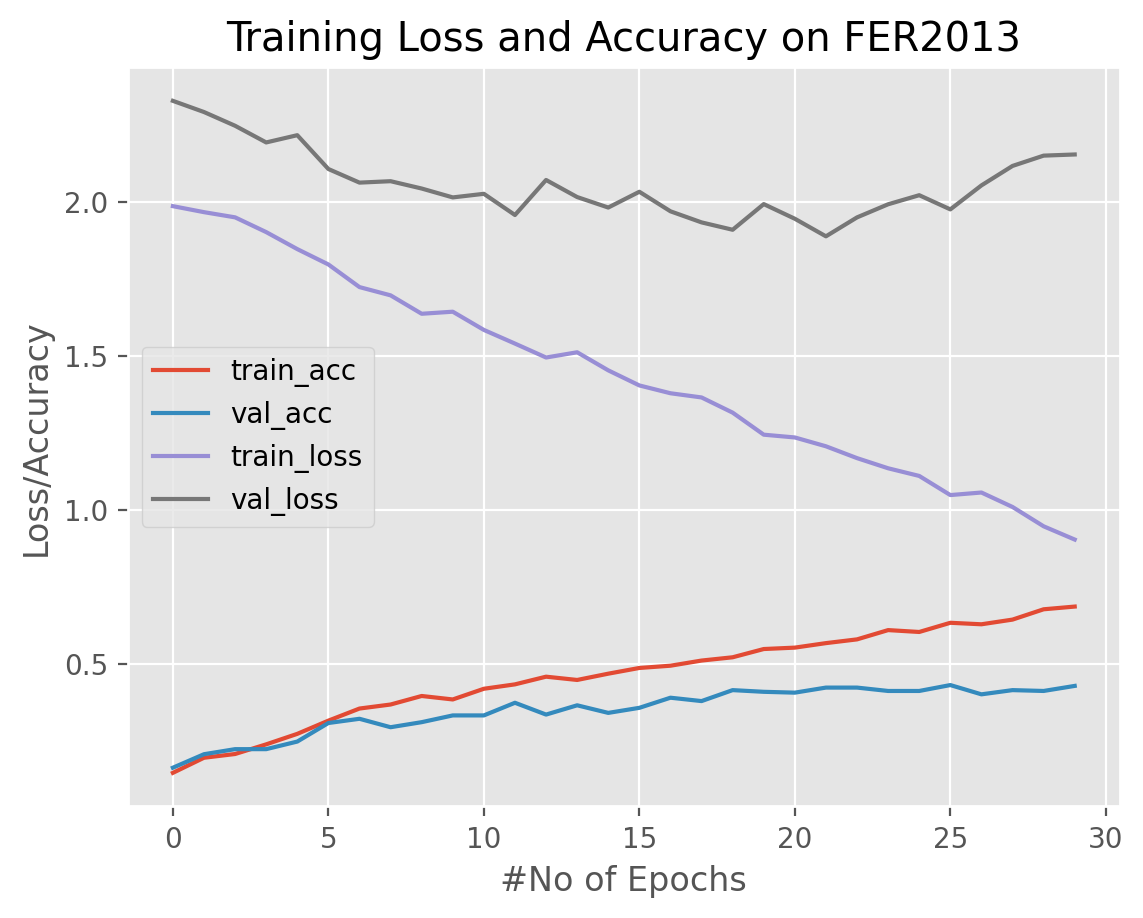

In [ ]:
# initialize a dictionary to save the training history
history = {
    "train_acc": [],
    "train_loss": [],
    "val_acc": [],
    "val_loss": []
}

# iterate through the epochs
print(f"[INFO] Training the model...")
#start_time = datetime.now()
 
for epoch in range(0, 30):
 
    print(f"[INFO] epoch: {epoch + 1}/{30}")
 
    """
    Training
    """
    model.train()
 
    total_train_loss = 0
    total_val_loss = 0

    # number of correct predictions
    train_correct = 0
    val_correct = 0
 
    # iterate through the train data
    for (data, target) in train_dataloader:
        # move the data into the device used for training,
        #data, target = data.to(device), target.to(device)
 
        # forward pass
        predictions = model(data)
        loss = criterion(predictions, target)
 
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_loss += loss
        train_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()

    """
    Validation
    """
    model.eval()  # disable dropout and dropout layers
 
    with torch.set_grad_enabled(False): #prevents pytorch from calculating the gradients
 
        # iterate through the validation set
        for (data, target) in val_dataloader:
            # move the data into the device used for testing
            #data, target = data.to(device), target.to(device)
 
            # forward pass
            predictions = model(data)
            loss = criterion(predictions, target)
 
            total_val_loss += loss
            val_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()

    # Save the current model (checkpoint) to a file
    model_path = "model_cnn"
    torch.save(model.state_dict(), model_path)
    
    # losses
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps
 
    # accuracies
    train_correct = train_correct / len(train_dataloader.dataset)
    val_correct = val_correct / len(val_dataloader.dataset)
 
    # print model training and validation records
    print(f"train loss: {avg_train_loss:.3f}  .. train accuracy: {train_correct:.3f}")
    print(f"val loss: {avg_val_loss:.3f}  .. val accuracy: {val_correct:.3f}", end='\n\n')
 
    # update the training and validation results
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    history['train_acc'].append(train_correct)
    history['val_loss'].append(avg_val_loss.cpu().detach().numpy())
    history['val_acc'].append(val_correct)
 
    # execute the learning rate scheduler and early stopping
    validation_loss = avg_val_loss.cpu().detach().numpy()
    # lr_scheduler(validation_loss)
    # early_stopping(validation_loss)
 
    # # stop the training procedure due to no improvement while validating the model
    # if early_stopping.early_stop_enabled:
    #     break
  
# plot the training loss and accuracy overtime
plt.style.use("ggplot")
plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel("#No of Epochs")
plt.title('Training Loss and Accuracy on FER2013')
plt.legend(loc='best')
#plt.savefig(args['plot'])

## **Load the Saved Model**

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data: 
      output = model(imgs)
        
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total

print(f"Testing accuracy: {get_accuracy(model, test_dataloader)}")

Testing accuracy: 0.3894993894993895


#**RNN Model**

## **Data Processing**

This section goes over data preprocessing, which includes the following steps:


*   Load .mid files for all of the emotions
*   Extract notes from the .mid files 
*   Map notes to an index and vice versa 
*   One-hot-encode outputs
*   Generate training and validation datasets

Some processing code from: https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook (For the Happy and Sad emotions)


### **Importing and Loading In Both Training And Validation Data From Google Drive**

Import the Training and Validation data (.mid files) for each emotion.

In [ ]:
# Load all the mid files for the given emotion
def load_midis(filepath):
    # Open .mid files and add to array
    midis = []
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i
            midi = converter.parse(tr)
            midis.append(midi)
    return midis

In [ ]:
# Load files from both validation and training set for a given emotion 
def load_sets(emotion):
    filepath_train = "/content/drive/MyDrive/RNN Training/{0}/".format(emotion)
    training_midis = load_midis(filepath_train)

    filepath_validation = "/content/drive/MyDrive/RNN Validation/{0}/".format(emotion)
    validation_midis = load_midis(filepath_validation)

    return training_midis + validation_midis

### **Load in all of the training and validation data for all of the emotions**

In [ ]:
angry_mids = load_sets("Angry")

In [ ]:
disgust_mids = load_sets("Disgust")

In [ ]:
fear_mids = load_sets("Fear")

In [ ]:
happy_mids = load_sets("Happy")

In [ ]:
neutral_mids = load_sets("Neutral")

In [ ]:
sad_mids = load_sets("Sad")

In [ ]:
surprise_mids = load_sets("Surprise")

### **Extract all of the notes from the mid files**

In [ ]:
# Extract notes from the stream of midi files
def extract_notes(all_midis):
    notes = []
    notes_to_parse = None

    # Iterate through all the midi files in the given array 
    for tune in all_midis:
        # Separate the tune into different instrument parts 
        tune_instrument = instrument.partitionByInstrument(tune)
        for part in tune_instrument.parts:
            if 'Piano' in str(part):
                # Break the part from tune_instrument into elements 
                notes_to_parse = part.recurse()
                for element in notes_to_parse:
                    # If the element is a note, then add it to the list, but if element is a chord, then convert chord into individual notes
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

In [ ]:
#Angry:
angry_notes = extract_notes(angry_mids)
angry_notes = angry_notes[0:10000]

In [ ]:
#Disgust:
disgust_notes = extract_notes(disgust_mids)
disgust_notes = disgust_notes[0:10000]

In [ ]:
#Fear:
fear_notes = extract_notes(fear_mids)
fear_notes = fear_notes[0:1000]

In [ ]:
#Happy:
happy_notes = extract_notes(happy_mids)
happy_notes = happy_notes[0:1000]

In [ ]:
#Neutral:
neutral_notes = extract_notes(neutral_mids)
neutral_notes = neutral_notes[0:1000]

In [ ]:
#Sad:
sad_notes = extract_notes(sad_mids)
sad_notes = sad_notes[0:1000]

In [ ]:
#Surprise:
surprise_notes = extract_notes(surprise_mids)
surprise_notes = surprise_notes[0:1000]

### **Map notes to an index and vice versa**

In [ ]:
# Remove any notes that do not occur too frequently - this is to reduce training time and focus on key notes 
def generate_mappings(notes):
    # Determine all the unique notes and their frequence
    unique_notes = list(set(notes))
    freq = dict(map(lambda x: (x, notes.count(x)), unique_notes))

    #dictionary having key as note index and value as note
    index_to_note_mapping = dict(enumerate(freq))
    
    #dictionary having key as note and value as note index
    note_to_index_mapping = dict(map(reversed, index_to_note_mapping.items()))
    
    return index_to_note_mapping, note_to_index_mapping

In [ ]:
#Angry:
angry_index_to_note, angry_note_to_index = generate_mappings(angry_notes)
angry_unique_notes = list(set(angry_notes))
angry_length_unique_notes = len(angry_unique_notes)

print("Angry: ")
print(f"Total Notes: {len(angry_notes)}")
print(f"Unique Notes: {angry_length_unique_notes}")

Angry: 
Total Notes: 10000
Unique Notes: 2148


In [ ]:
#Disgust:
disgust_index_to_note, disgust_note_to_index = generate_mappings(disgust_notes)
disgust_unique_notes = list(set(disgust_notes))
disgust_length_unique_notes = len(disgust_unique_notes)

print("Disgust: ")
print(f"Total Notes: {len(disgust_notes)}")
print(f"Unique Notes: {disgust_length_unique_notes}")

Disgust: 
Total Notes: 6319
Unique Notes: 1777


In [ ]:
#Fear:
fear_index_to_note, fear_note_to_index = generate_mappings(fear_notes)
fear_unique_notes = list(set(fear_notes))
fear_length_unique_notes = len(fear_unique_notes)

print("Fear: ")
print(f"Total Notes: {len(fear_notes)}")
print(f"Unique Notes: {fear_length_unique_notes}")

Fear: 
Total Notes: 1000
Unique Notes: 619


In [ ]:
#Happy:
happy_index_to_note, happy_note_to_index = generate_mappings(happy_notes)
happy_unique_notes = list(set(happy_notes))
happy_length_unique_notes = len(happy_unique_notes)

print("Happy: ")
print(f"Total Notes: {len(happy_notes)}")
print(f"Unique Notes: {happy_length_unique_notes}")

Happy: 
Total Notes: 1000
Unique Notes: 488


In [ ]:
#Neutral:
neutral_index_to_note, neutral_note_to_index = generate_mappings(neutral_notes)
neutral_unique_notes = list(set(neutral_notes))
neutral_length_unique_notes = len(neutral_unique_notes)

print("Neutral: ")
print(f"Total Notes: {len(neutral_notes)}")
print(f"Unique Notes: {neutral_length_unique_notes}")

Neutral: 
Total Notes: 1000
Unique Notes: 456


In [ ]:
#Sad:
sad_index_to_note, sad_note_to_index = generate_mappings(sad_notes)
sad_unique_notes = list(set(sad_notes))
sad_length_unique_notes = len(sad_unique_notes)

print("Sad: ")
print(f"Total Notes: {len(sad_notes)}")
print(f"Unique Notes: {sad_length_unique_notes}")

Sad: 
Total Notes: 1000
Unique Notes: 250


In [ ]:
#Surprise:
surprise_index_to_note, surprise_note_to_index = generate_mappings(surprise_notes)
surprise_unique_notes = list(set(surprise_notes))
surprise_length_unique_notes = len(surprise_unique_notes)

print("Surprise: ")
print(f"Total Notes: {len(surprise_notes)}")
print(f"Unique Notes: {surprise_length_unique_notes}")

Surprise: 
Total Notes: 1000
Unique Notes: 501


###**Split data into batches**

In [ ]:
def split_data_into_batches(notes, note_to_index, length):
  features = []
  targets = []

  length_number_notes = len(notes)
  num_notes = (length * math.floor(length_number_notes / length))

  count = 0
  for i in range(0, num_notes - length, 1):
      feature = notes[i:i + length]
      target = notes[i + length]

      features.append([note_to_index[j] for j in feature])
      targets.append(note_to_index[target])

  return features, targets

In [ ]:
#Angry:
angry_window_length = 16
angry_features, angry_targets = split_data_into_batches(angry_notes, angry_note_to_index, angry_window_length)
angry_inputs = torch.tensor(angry_features, dtype=torch.float32).reshape(len(angry_features), angry_window_length, 1)
angry_inputs = angry_inputs / float(angry_length_unique_notes)
angry_outputs = torch.tensor(angry_targets)

In [ ]:
#Disgust
disgust_window_length = 16
disgust_features, disgust_targets = split_data_into_batches(disgust_notes, disgust_note_to_index, disgust_window_length)
disgust_inputs = torch.tensor(disgust_features, dtype=torch.float32).reshape(len(disgust_features), disgust_window_length, 1)
disgust_inputs = disgust_inputs / float(disgust_length_unique_notes)
disgust_outputs = torch.tensor(disgust_targets)

In [ ]:
#Fear
fear_window_length = 16
fear_features, fear_targets = split_data_into_batches(fear_notes, fear_note_to_index, fear_window_length)
fear_inputs = torch.tensor(fear_features, dtype=torch.float32).reshape(len(fear_features), fear_window_length, 1)
fear_inputs = fear_inputs / float(fear_length_unique_notes)
fear_outputs = torch.tensor(fear_targets)

In [ ]:
#Happy
happy_window_length = 16
happy_features, happy_targets = split_data_into_batches(happy_notes, happy_note_to_index, happy_window_length)
happy_inputs = torch.tensor(happy_features, dtype=torch.float32).reshape(len(happy_features), happy_window_length, 1)
happy_inputs = happy_inputs / float(happy_length_unique_notes)
happy_outputs = torch.tensor(happy_targets)

In [ ]:
#Neutral
neutral_window_length = 16
neutral_features, neutral_targets = split_data_into_batches(neutral_notes, neutral_note_to_index, neutral_window_length)
neutral_inputs = torch.tensor(neutral_features, dtype=torch.float32).reshape(len(neutral_features), neutral_window_length, 1)
neutral_inputs = neutral_inputs / float(neutral_length_unique_notes)
neutral_outputs = torch.tensor(neutral_targets)

In [ ]:
#Sad
sad_window_length = 16
sad_features, sad_targets = split_data_into_batches(sad_notes, sad_note_to_index, sad_window_length)
sad_inputs = torch.tensor(sad_features, dtype=torch.float32).reshape(len(sad_features), sad_window_length, 1)
sad_inputs = sad_inputs / float(sad_length_unique_notes)
sad_outputs = torch.tensor(sad_targets)

In [ ]:
#Surprise
surprise_window_length = 16
surprise_features, surprise_targets = split_data_into_batches(surprise_notes, surprise_note_to_index, surprise_window_length)
surprise_inputs = torch.tensor(surprise_features, dtype=torch.float32).reshape(len(surprise_features), surprise_window_length, 1)
surprise_inputs = surprise_inputs / float(surprise_length_unique_notes)
surprise_outputs = torch.tensor(surprise_targets)

## **Models**
Recurrent Neural Network Model with LSTM (From Lecture 8)

In [ ]:
#Angry:
class AngryMusicRNN(nn.Module):
    def __init__(self):
        super(AngryMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, angry_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Disgust:
class DisgustMusicRNN(nn.Module):
    def __init__(self):
        super(DisgustMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, disgust_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Fear:
class FearMusicRNN(nn.Module):
    def __init__(self):
        super(FearMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, fear_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Happy:
class HappyMusicRNN(nn.Module):
    def __init__(self):
        super(HappyMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, happy_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Nuetral:
class NuetralMusicRNN(nn.Module):
    def __init__(self):
        super(NuetralMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(128, neutral_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Sad:
class SadMusicRNN(nn.Module):
    def __init__(self):
        super(SadMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.6)
        self.linear = nn.Linear(128, sad_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#Surprise:
class SurpriseMusicRNN(nn.Module):
    def __init__(self):
        super(SurpriseMusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.6)
        self.linear = nn.Linear(128, surprise_length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

## **Training**

### **Training Code**

In [ ]:
def get_model_name(name, batch_size, learning_rate, emotion):
    path = "model_{0}_bs{1}_lr{2}_emotion{3}".format(name, batch_size, learning_rate, emotion)
    return path

def train(model, emotion, train_loader, validation_loader, batch_size, num_epochs=5, 
          learning_rate=1e-3, plot=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, validation_loss = [], [], []

    for epoch in range(num_epochs):
        # Train the model and append the train loss
        for inputs, output in train_loader:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, output)
            loss.backward()
            optimizer.step()
        
        train_loss.append(float(loss))
        
        # Compute validation loss
        for inputs, output in validation_loader:
            pred = model(inputs)
            loss = criterion(pred, output)
        validation_loss.append(float(loss))
        iters.append(epoch)

        # Display information
        if plot:
            print(  f'Epoch {epoch}: '
                    f'\tTrain Loss: {train_loss[epoch]}'
                    f'\t\tValidation Loss: {validation_loss[epoch]} ')

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, emotion)
    torch.save(model.state_dict(), model_path)
        

    print("=======================================")
    print("Final Training Loss: {}\n".format(train_loss[-1]))   
    print("Final Validation Loss: {}\n".format(validation_loss[-1])) 

    #Plotting
    if plot:
        plt.style.use("ggplot")
        plt.title(f"Train vs. Validation Loss for \"{emotion}\"")
        plt.plot(iters, train_loss, label="Train")
        plt.plot(iters, validation_loss, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

###**Training Models**

Epoch 0: 	Train Loss: 6.137005805969238		Validation Loss: 5.657759666442871 
Epoch 1: 	Train Loss: 5.993402004241943		Validation Loss: 7.682934761047363 
Epoch 2: 	Train Loss: 6.50841760635376		Validation Loss: 6.826354026794434 
Epoch 3: 	Train Loss: 6.407631874084473		Validation Loss: 5.600318908691406 
Epoch 4: 	Train Loss: 6.446671962738037		Validation Loss: 5.370190143585205 
Epoch 5: 	Train Loss: 4.939584255218506		Validation Loss: 5.677618026733398 
Epoch 6: 	Train Loss: 5.3109025955200195		Validation Loss: 5.105973243713379 
Epoch 7: 	Train Loss: 6.864867210388184		Validation Loss: 7.378811359405518 
Epoch 8: 	Train Loss: 5.624786376953125		Validation Loss: 6.255472183227539 
Epoch 9: 	Train Loss: 6.420440673828125		Validation Loss: 5.634861946105957 
Epoch 10: 	Train Loss: 6.173170566558838		Validation Loss: 5.181454181671143 
Epoch 11: 	Train Loss: 5.506313323974609		Validation Loss: 6.042281627655029 
Epoch 12: 	Train Loss: 5.255844593048096		Validation Loss: 5.8201828002929

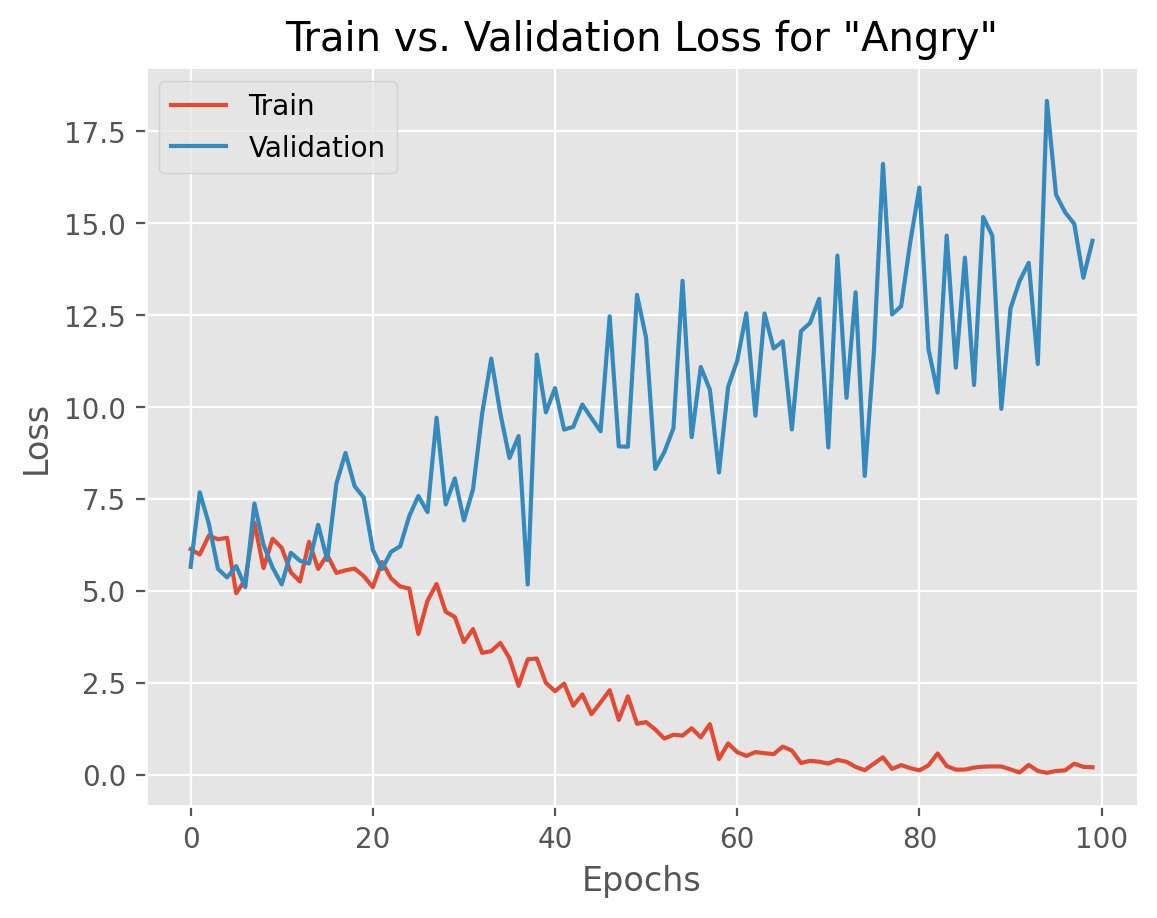

In [ ]:
#Angry 
num_epochs = 100
learning_rate = 0.001 
batch_size = 32
hidden_size = 256
emotion = "Angry"

angry_full_dataset = torch.utils.data.TensorDataset(angry_inputs, angry_outputs)
angry_train_size = int(0.8 * len(angry_full_dataset))
angry_validation_size = len(angry_full_dataset) - angry_train_size

train_dataset, validation_dataset = torch.utils.data.random_split(angry_full_dataset, [angry_train_size, angry_validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

angry_music_rnn_model = AngryMusicRNN()
train(angry_music_rnn_model, emotion, train_loader, validation_loader, batch_size, num_epochs, learning_rate)

# Final hyperparameters for music production: lr=0.001, batch_size=32, hidden_size=256, window_size=16, dropout=0.2
# Final hyperparameters for loss curve: lr=0.0001, batch_size=1024, hidden_size=128, window_size=16, dropout=0.6

Epoch 0: 	Train Loss: 6.444643497467041		Validation Loss: 5.4129486083984375 
Epoch 1: 	Train Loss: 8.664645195007324		Validation Loss: 5.7574286460876465 
Epoch 2: 	Train Loss: 6.778923511505127		Validation Loss: 7.159562110900879 
Epoch 3: 	Train Loss: 6.7542500495910645		Validation Loss: 6.577437400817871 
Epoch 4: 	Train Loss: 5.8643951416015625		Validation Loss: 6.34129524230957 
Epoch 5: 	Train Loss: 7.2127299308776855		Validation Loss: 4.996237277984619 
Epoch 6: 	Train Loss: 5.3120341300964355		Validation Loss: 8.122315406799316 
Epoch 7: 	Train Loss: 5.875484943389893		Validation Loss: 7.106236457824707 
Epoch 8: 	Train Loss: 6.377286911010742		Validation Loss: 7.406014442443848 
Epoch 9: 	Train Loss: 6.71058464050293		Validation Loss: 7.342576026916504 
Epoch 10: 	Train Loss: 5.938375949859619		Validation Loss: 4.334258079528809 
Epoch 11: 	Train Loss: 5.638373851776123		Validation Loss: 8.668745040893555 
Epoch 12: 	Train Loss: 6.723241329193115		Validation Loss: 6.916779518

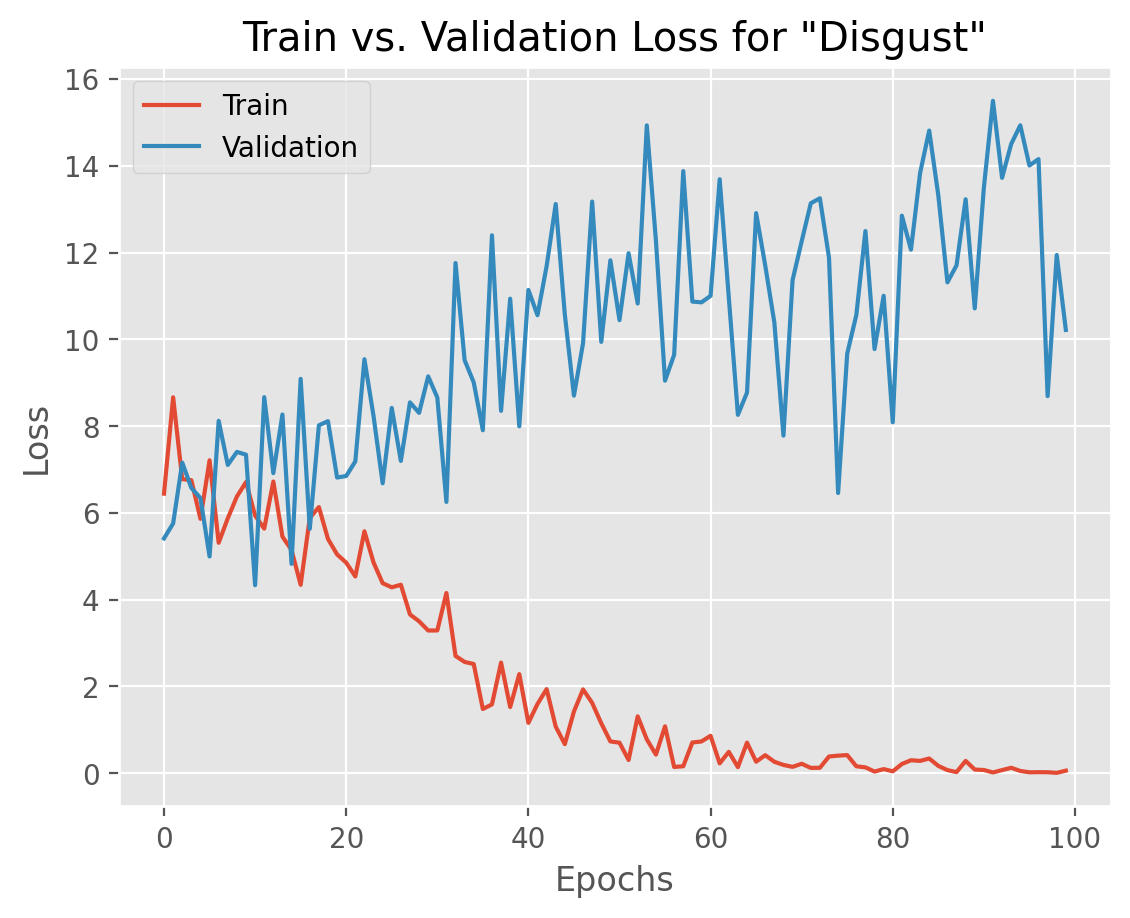

In [ ]:
#Disgust
num_epochs = 100
learning_rate = 0.001
batch_size = 32
hidden_size = 128
emotion = "Disgust"

disgust_full_dataset = torch.utils.data.TensorDataset(disgust_inputs, disgust_outputs)
disgust_train_size = int(0.8 * len(disgust_full_dataset))
disgust_validation_size = len(disgust_full_dataset) - disgust_train_size

train_dataset, validation_dataset = torch.utils.data.random_split(disgust_full_dataset, [disgust_train_size, disgust_validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

disgust_music_rnn_model = DisgustMusicRNN()
train(disgust_music_rnn_model, emotion, train_loader, validation_loader, batch_size, num_epochs, learning_rate)

# Final hyperparameters for music production: lr=0.001, batch_size=32, hidden_size=256, window_size=16, dropout=0.2
# Final hyperparameters for loss curve: lr=0.00008, batch_size=1024, hidden_size=128, window_size=16, dropout=0.2

Epoch 0: 	Train Loss: 6.3296380043029785		Validation Loss: 6.373210906982422 
Epoch 1: 	Train Loss: 6.308504581451416		Validation Loss: 6.846141815185547 
Epoch 2: 	Train Loss: 6.139642238616943		Validation Loss: 7.554903507232666 
Epoch 3: 	Train Loss: 5.733020782470703		Validation Loss: 6.148968696594238 
Epoch 4: 	Train Loss: 6.158850193023682		Validation Loss: 6.112729072570801 
Epoch 5: 	Train Loss: 6.6097412109375		Validation Loss: 8.713912963867188 
Epoch 6: 	Train Loss: 6.231286525726318		Validation Loss: 7.175500392913818 
Epoch 7: 	Train Loss: 6.031579494476318		Validation Loss: 7.057041168212891 
Epoch 8: 	Train Loss: 6.303325653076172		Validation Loss: 8.284863471984863 
Epoch 9: 	Train Loss: 6.000713348388672		Validation Loss: 10.25040340423584 
Epoch 10: 	Train Loss: 5.7749552726745605		Validation Loss: 10.28863525390625 
Epoch 11: 	Train Loss: 6.094212055206299		Validation Loss: 7.802677631378174 
Epoch 12: 	Train Loss: 5.565632343292236		Validation Loss: 9.1218729019165

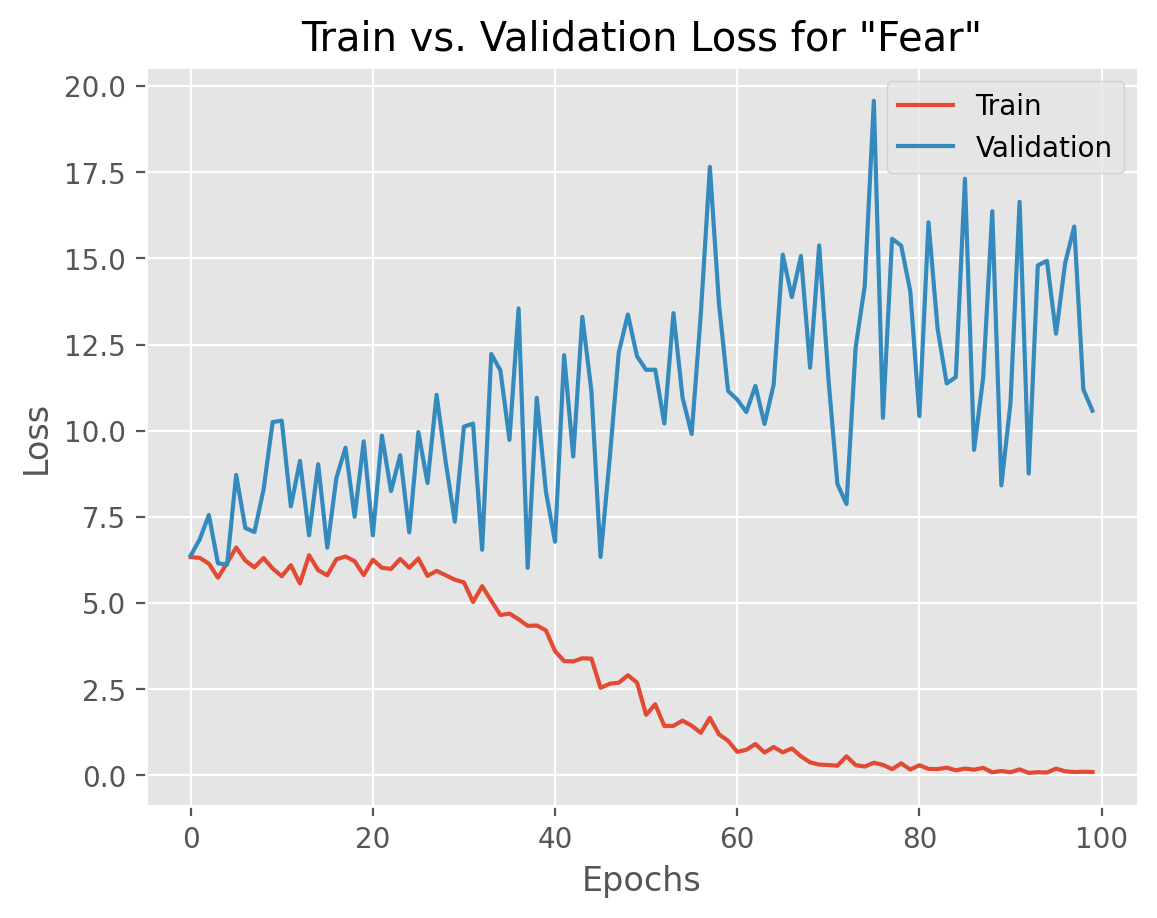

In [ ]:
#Fear
num_epochs = 100
learning_rate = 0.001 
batch_size = 32
hidden_size = 256
emotion = "Fear"

fear_full_dataset = torch.utils.data.TensorDataset(fear_inputs, fear_outputs)
fear_train_size = int(0.8 * len(fear_full_dataset))
fear_validation_size = len(fear_full_dataset) - fear_train_size

train_dataset, validation_dataset = torch.utils.data.random_split(fear_full_dataset, [fear_train_size, fear_validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

fear_music_rnn_model = FearMusicRNN()
train(fear_music_rnn_model, emotion, train_loader, validation_loader, batch_size, num_epochs, learning_rate)

# Final hyperparameters for music production: lr=0.001, batch_size=32, hidden_size=256, window_size=16, dropout=0.2
# Final hyperparameters for loss curve: lr=0.0001, batch_size=512, hidden_size=128, window_size=16, dropout=0.2

Epoch 0: 	Train Loss: 5.068254470825195		Validation Loss: 6.156792640686035 
Epoch 1: 	Train Loss: 5.23232889175415		Validation Loss: 5.785381317138672 
Epoch 2: 	Train Loss: 4.905858039855957		Validation Loss: 5.564274787902832 
Epoch 3: 	Train Loss: 5.9186625480651855		Validation Loss: 7.772383689880371 
Epoch 4: 	Train Loss: 5.4974141120910645		Validation Loss: 7.292146682739258 
Epoch 5: 	Train Loss: 5.325427532196045		Validation Loss: 7.4263596534729 
Epoch 6: 	Train Loss: 6.01171875		Validation Loss: 3.3073694705963135 
Epoch 7: 	Train Loss: 5.611974239349365		Validation Loss: 5.941184997558594 
Epoch 8: 	Train Loss: 5.197635173797607		Validation Loss: 5.754446029663086 
Epoch 9: 	Train Loss: 5.131105899810791		Validation Loss: 8.580734252929688 
Epoch 10: 	Train Loss: 5.217984676361084		Validation Loss: 7.094114303588867 
Epoch 11: 	Train Loss: 4.606106758117676		Validation Loss: 7.388545989990234 
Epoch 12: 	Train Loss: 5.216619491577148		Validation Loss: 6.519739151000977 
Epo

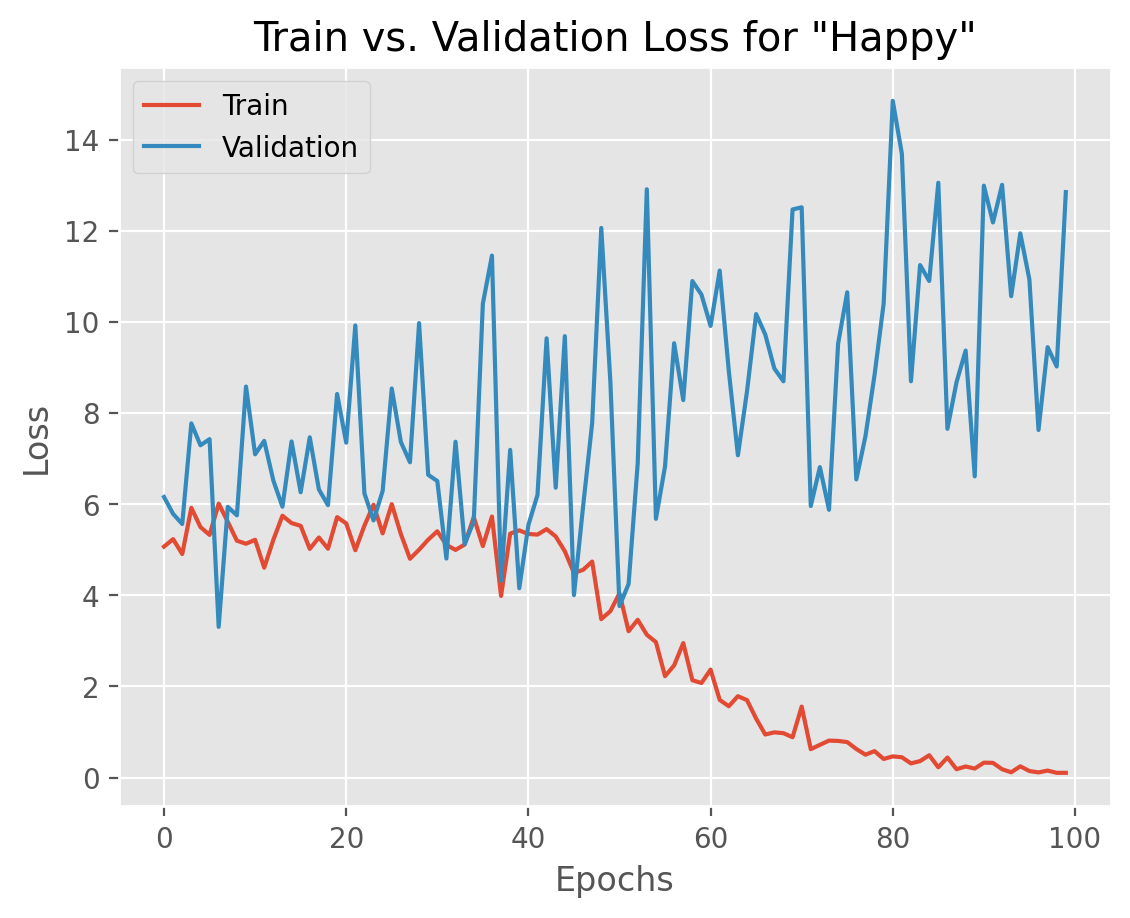

In [ ]:
#Happy
num_epochs = 100
learning_rate = 0.001 
batch_size = 32
hidden_size = 128
emotion = "Happy"

happy_full_dataset = torch.utils.data.TensorDataset(happy_inputs, happy_outputs)
happy_train_size = int(0.8 * len(happy_full_dataset))
happy_validation_size = len(happy_full_dataset) - happy_train_size

train_dataset, validation_dataset = torch.utils.data.random_split(happy_full_dataset, [happy_train_size, happy_validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

happy_music_rnn_model = HappyMusicRNN()
train(happy_music_rnn_model, emotion, train_loader, validation_loader, batch_size, num_epochs, learning_rate)

Epoch 0: 	Train Loss: 6.0590500831604		Validation Loss: 6.087586402893066 
Epoch 1: 	Train Loss: 6.150410175323486		Validation Loss: 7.891619682312012 
Epoch 2: 	Train Loss: 5.983290195465088		Validation Loss: 6.4419379234313965 
Epoch 3: 	Train Loss: 5.746504306793213		Validation Loss: 8.257284164428711 
Epoch 4: 	Train Loss: 5.538448333740234		Validation Loss: 8.412635803222656 
Epoch 5: 	Train Loss: 5.3917717933654785		Validation Loss: 6.322062969207764 
Epoch 6: 	Train Loss: 5.464178085327148		Validation Loss: 6.244241237640381 
Epoch 7: 	Train Loss: 4.981995582580566		Validation Loss: 7.675221920013428 
Epoch 8: 	Train Loss: 5.8998284339904785		Validation Loss: 8.935511589050293 
Epoch 9: 	Train Loss: 5.330948829650879		Validation Loss: 5.134291648864746 
Epoch 10: 	Train Loss: 6.155038356781006		Validation Loss: 6.261881351470947 
Epoch 11: 	Train Loss: 5.679683685302734		Validation Loss: 5.912860870361328 
Epoch 12: 	Train Loss: 5.83419942855835		Validation Loss: 6.3782830238342

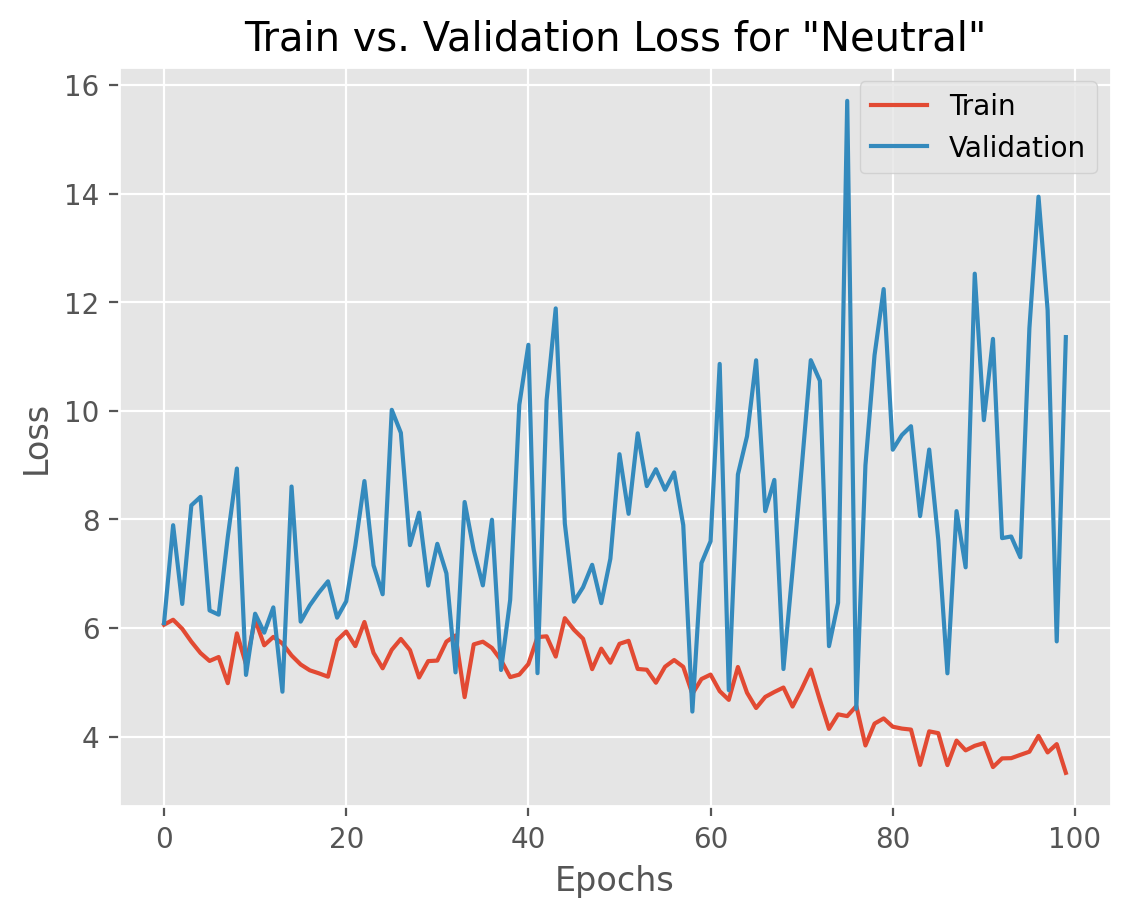

In [ ]:
#Neutral
neutral_full_dataset = torch.utils.data.TensorDataset(neutral_inputs, neutral_outputs)
neutral_train_size = int(0.8 * len(neutral_full_dataset))
neutral_validation_size = len(neutral_full_dataset) - neutral_train_size

neutral_train_dataset, neutral_validation_dataset = torch.utils.data.random_split(neutral_full_dataset, [neutral_train_size, neutral_validation_size])
neutral_train_loader = torch.utils.data.DataLoader(neutral_train_dataset, shuffle=True, batch_size=32)
neutral_validation_loader = torch.utils.data.DataLoader(neutral_validation_dataset, shuffle=True, batch_size=32)

neutral_music_rnn_model = NuetralMusicRNN()
train(neutral_music_rnn_model, emotion = "Neutral", train_loader = neutral_train_loader, validation_loader = neutral_validation_loader, batch_size = 32, num_epochs = 100, learning_rate = 0.0008)

Epoch 0: 	Train Loss: 5.056131839752197		Validation Loss: 5.3023576736450195 
Epoch 1: 	Train Loss: 4.642198085784912		Validation Loss: 5.698046684265137 
Epoch 2: 	Train Loss: 4.646446704864502		Validation Loss: 4.771634578704834 
Epoch 3: 	Train Loss: 4.062478542327881		Validation Loss: 3.6833112239837646 
Epoch 4: 	Train Loss: 4.662224769592285		Validation Loss: 4.581933975219727 
Epoch 5: 	Train Loss: 5.033586502075195		Validation Loss: 5.64506721496582 
Epoch 6: 	Train Loss: 4.64007043838501		Validation Loss: 4.7468085289001465 
Epoch 7: 	Train Loss: 5.028655529022217		Validation Loss: 3.4342193603515625 
Epoch 8: 	Train Loss: 4.093369007110596		Validation Loss: 6.561338424682617 
Epoch 9: 	Train Loss: 4.800739288330078		Validation Loss: 5.373582363128662 
Epoch 10: 	Train Loss: 5.08345365524292		Validation Loss: 6.069423675537109 
Epoch 11: 	Train Loss: 4.707812786102295		Validation Loss: 5.855657577514648 
Epoch 12: 	Train Loss: 5.32165002822876		Validation Loss: 5.3480877876281

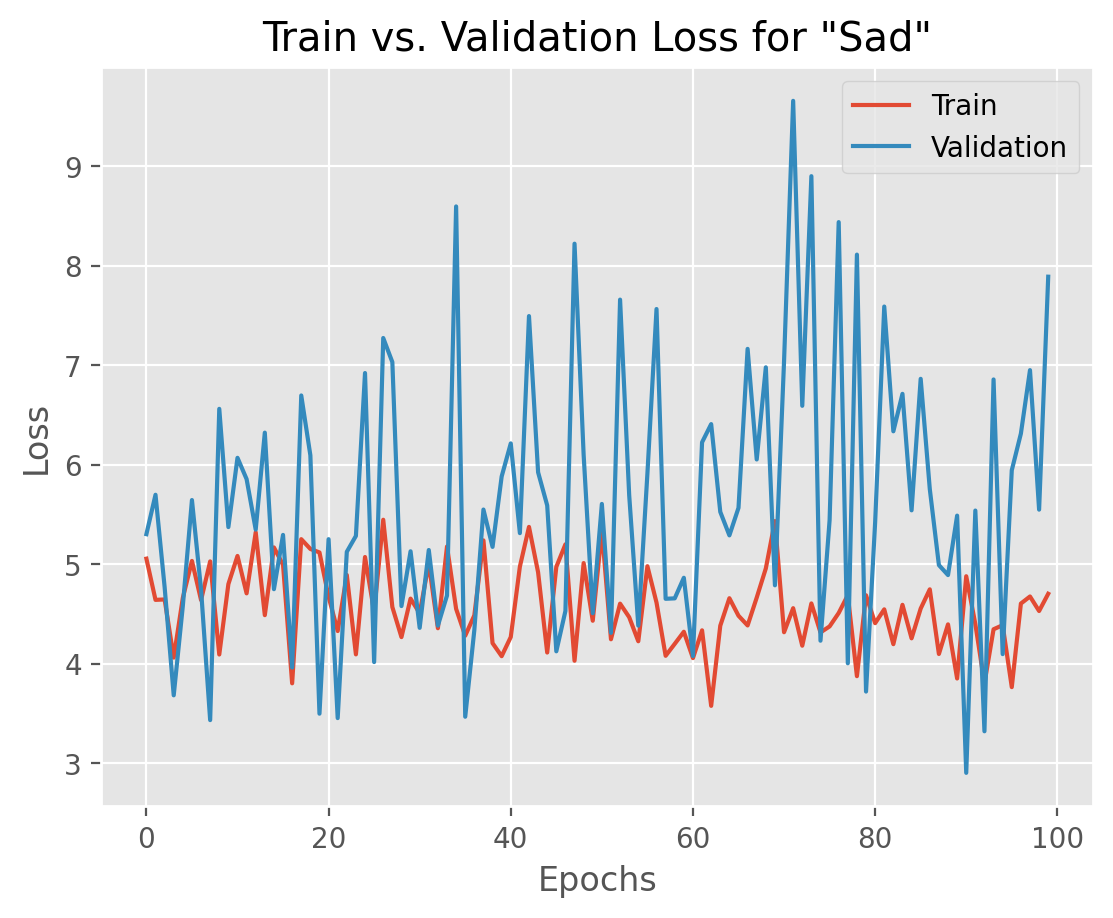

In [ ]:
#Sad
sad_full_dataset = torch.utils.data.TensorDataset(sad_inputs, sad_outputs)
sad_train_size = int(0.8 * len(sad_full_dataset))
sad_validation_size = len(sad_full_dataset) - sad_train_size

sad_train_dataset, sad_validation_dataset = torch.utils.data.random_split(sad_full_dataset, [sad_train_size, sad_validation_size])
sad_train_loader = torch.utils.data.DataLoader(sad_train_dataset, shuffle=True, batch_size=32)
sad_validation_loader = torch.utils.data.DataLoader(sad_validation_dataset, shuffle=True, batch_size=32)

sad_music_rnn_model = SadMusicRNN()
train(sad_music_rnn_model, emotion = "Sad", train_loader = sad_train_loader, validation_loader = sad_validation_loader, batch_size = 32, num_epochs = 100, learning_rate = 0.0009)

Epoch 0: 	Train Loss: 6.233902454376221		Validation Loss: 6.204877853393555 
Epoch 1: 	Train Loss: 6.16410493850708		Validation Loss: 7.118017673492432 
Epoch 2: 	Train Loss: 6.142719268798828		Validation Loss: 6.871327877044678 
Epoch 3: 	Train Loss: 5.799659252166748		Validation Loss: 7.056070327758789 
Epoch 4: 	Train Loss: 6.153672695159912		Validation Loss: 5.586917400360107 
Epoch 5: 	Train Loss: 5.841716766357422		Validation Loss: 7.187874794006348 
Epoch 6: 	Train Loss: 6.104095935821533		Validation Loss: 6.294775009155273 
Epoch 7: 	Train Loss: 6.053452014923096		Validation Loss: 5.070778846740723 
Epoch 8: 	Train Loss: 6.276352405548096		Validation Loss: 7.033365726470947 
Epoch 9: 	Train Loss: 5.819732666015625		Validation Loss: 6.249418258666992 
Epoch 10: 	Train Loss: 5.939191818237305		Validation Loss: 6.380474090576172 
Epoch 11: 	Train Loss: 5.603222370147705		Validation Loss: 7.167433261871338 
Epoch 12: 	Train Loss: 5.9094557762146		Validation Loss: 6.9286956787109375

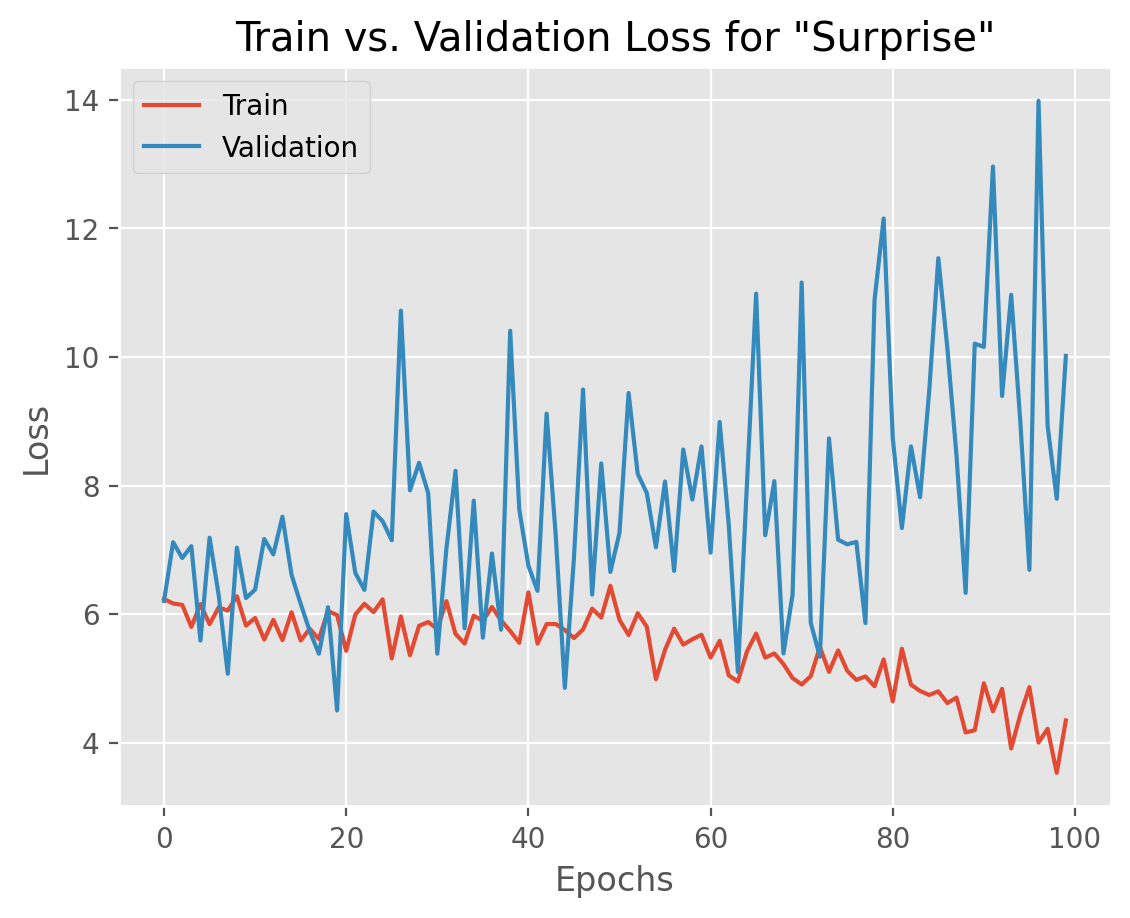

In [ ]:
#Surprise
surprise_full_dataset = torch.utils.data.TensorDataset(surprise_inputs, surprise_outputs)
surprise_train_size = int(0.8 * len(surprise_full_dataset))
surprise_validation_size = len(surprise_full_dataset) - surprise_train_size

surprise_train_dataset, surprise_validation_dataset = torch.utils.data.random_split(surprise_full_dataset, [surprise_train_size, surprise_validation_size])
surprise_train_loader = torch.utils.data.DataLoader(surprise_train_dataset, shuffle=True, batch_size=32)
surprise_validation_loader = torch.utils.data.DataLoader(surprise_validation_dataset, shuffle=True, batch_size=32)

surprise_music_rnn_model = SurpriseMusicRNN()
train(surprise_music_rnn_model, emotion = "Surprise", train_loader = surprise_train_loader, validation_loader = surprise_validation_loader, batch_size = 32, num_epochs = 100, learning_rate = 0.0009)

## **Music Generation**

### **Music Generation Functions**

In [ ]:
# Convert the list of notes/chords back to music     
def chords_n_notes(tune):
    melody = []
    offset = 0 
    for i in tune:
        # pattern is a chord then separate the chord into notes
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") 
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    melody_midi = stream.Stream(melody)   
    return melody_midi

In [ ]:
def melody_generator(window, note_to_produce, notes, note_to_index, index_to_note, length_unique_notes, model):
    # Generate seed - first 16 notes
    seq_length = window
    start = np.random.randint(0, len(notes) - seq_length)
    prompt = notes[start:start + seq_length]
    pattern = [note_to_index[c] for c in prompt]
    
    model.eval()
    for i in range(note_to_produce):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(length_unique_notes)
        x = torch.tensor(x, dtype=torch.float32)

        # generate logits as output from the model
        prediction = model(x)
        
        # convert logits into one character
        index = int(prediction.argmax())
        result = index_to_note[index]

        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
        music = [index_to_note[char] for char in pattern]

    melody = chords_n_notes(music)
    melody_midi = stream.Stream(melody)   
    return music, melody_midi

In [ ]:
# Display the image of the generated music
def show(music):
    # display(Image(str(music.write("lily.png"))))
    display(Image(str(music.write("lily.png"))))

### **Generate Music For Each Emotion**

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


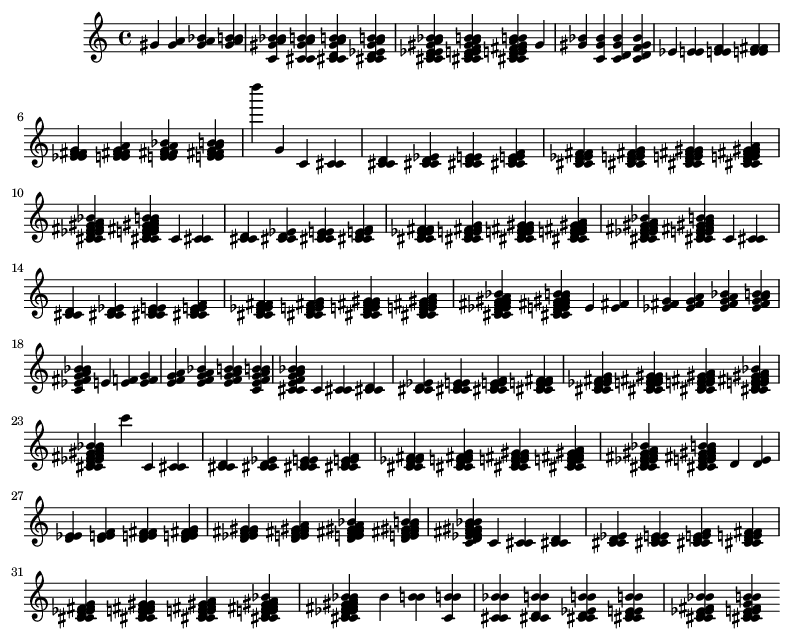

'Generated_Angry_Melody.mid'

In [ ]:
# Angry:
# Getting The Notes and Melody Created By The Model
angry_music, angry_melody = melody_generator(16, 20, angry_notes, angry_note_to_index, angry_index_to_note, angry_length_unique_notes, angry_music_rnn_model)
show(angry_melody)

# To Save The Generated Melody
angry_melody.write('midi','Generated_Angry_Melody.mid')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


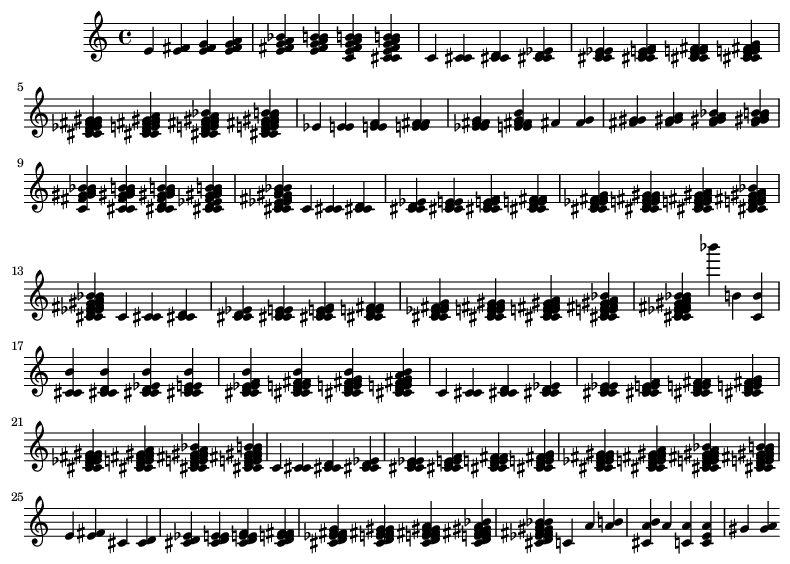

'Generated_Disgust_Melody.mid'

In [ ]:
# Disgust:

# Getting The Notes and Melody Created By The Model
disgust_music, disgust_melody = melody_generator(16, 20, disgust_notes, disgust_note_to_index, disgust_index_to_note, disgust_length_unique_notes, disgust_music_rnn_model)
show(disgust_melody)

# To Save The Generated Melody
disgust_melody.write('midi','Generated_Disgust_Melody.mid')

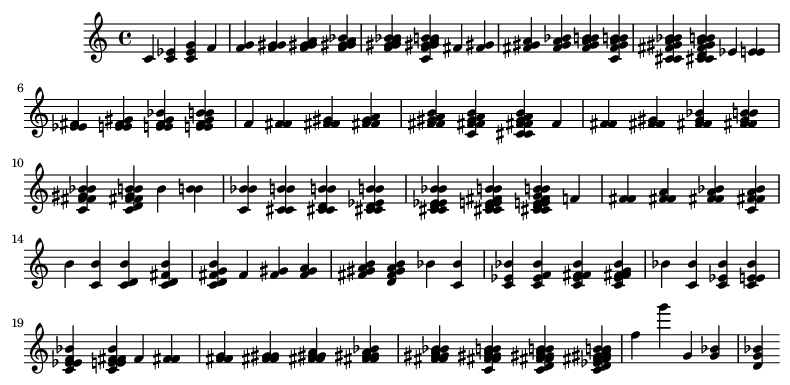

'Generated_Fear_Melody.mid'

In [ ]:
# Fear:

# Getting The Notes and Melody Created By The Model
fear_music, fear_melody = melody_generator(16, 20, fear_notes, fear_note_to_index, fear_index_to_note, fear_length_unique_notes, fear_music_rnn_model)
show(fear_melody)

# To Save The Generated Melody
fear_melody.write('midi','Generated_Fear_Melody.mid')

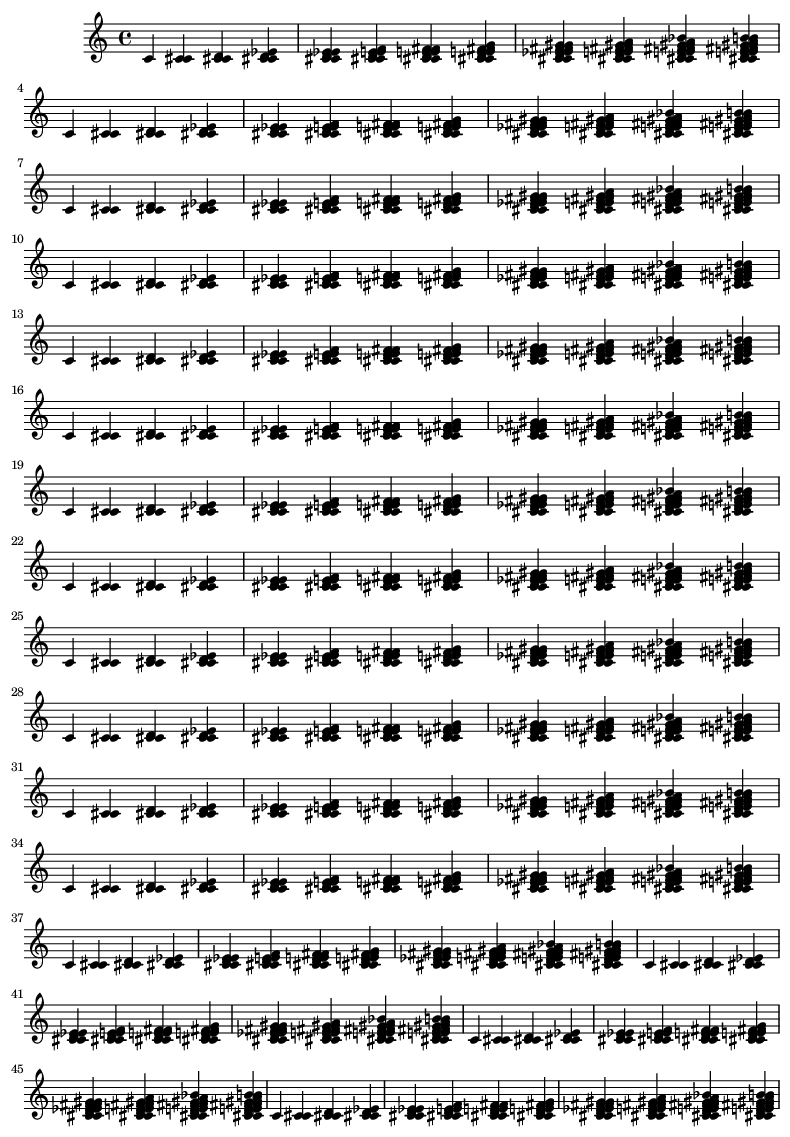

'Generated_Happy_Melody.mid'

In [ ]:
# Happy:

# Getting The Notes and Melody Created By The Model
happy_music, happy_melody = melody_generator(16, 20, happy_notes, happy_note_to_index, happy_index_to_note, happy_length_unique_notes, happy_music_rnn_model)
show(happy_melody)

# To Save The Generated Melody
happy_melody.write('midi','Generated_Happy_Melody.mid')

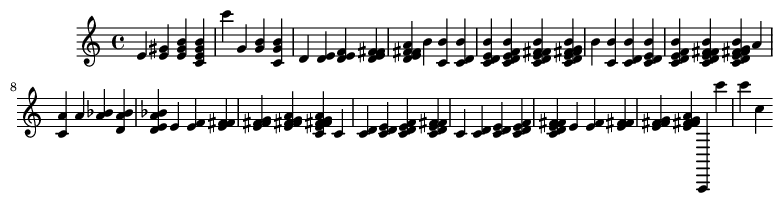

'Generated_Neutral_Melody.mid'

In [ ]:
# Nuetral:

# Getting The Notes and Melody Created By The Model
neutral_music, neutral_melody = melody_generator(16, 20, neutral_notes, neutral_note_to_index, neutral_index_to_note, neutral_length_unique_notes, neutral_music_rnn_model)
show(neutral_melody)

# To Save The Generated Melody
neutral_melody.write('midi','Generated_Neutral_Melody.mid')

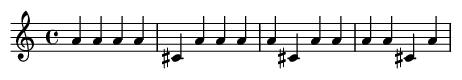

'Generated_Sad_Melody.mid'

In [ ]:
# Sad:

# Getting The Notes and Melody Created By The Model
sad_music, sad_melody = melody_generator(16, 20, sad_notes, sad_note_to_index, sad_index_to_note, sad_length_unique_notes, sad_music_rnn_model)
show(sad_melody)

# To Save The Generated Melody
sad_melody.write('midi','Generated_Sad_Melody.mid')

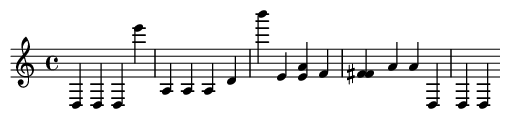

'Generated_Surprise_Melody.mid'

In [ ]:
# Surprise:

# Getting The Notes and Melody Created By The Model
surprise_music, surprise_melody = melody_generator(16, 20, surprise_notes, surprise_note_to_index, surprise_index_to_note, surprise_length_unique_notes, surprise_music_rnn_model)
show(surprise_melody)

# To Save The Generated Melody
surprise_melody.write('midi','Generated_Surprise_Melody.mid')

## **Baseline Model**

###**Functions**

In [ ]:
def count_occurence_of_note(notes, unique_notes):
    note_occurence_dictionary = {}
    for note in unique_notes: 
        count_note = notes.count(note)
        note_occurence_dictionary[note] = count_note
    sorted_note_occurence_dictionary = sorted(note_occurence_dictionary.items(), key=lambda x: x[1], reverse=True)
    return sorted_note_occurence_dictionary

In [ ]:
# Baseline model 
import math 
def Baseline_Model(Note_Count, sorted_note_occurence_dictionary):
    Notes_Generated=[]
    num_repeat = math.floor(Note_Count/10)

    for i in range(num_repeat):
        for i in range(10):
            Notes_Generated.append(sorted_note_occurence_dictionary[i][0])
    
    Melody = chords_n_notes(Notes_Generated)
    Melody_midi = stream.Stream(Melody)   
    return Notes_Generated, Melody_midi

###**Baseline Model for All Emotions**

In [ ]:
#Angry:
angry_sorted_note_occurence_dictionary = count_occurence_of_note(angry_notes, angry_unique_notes)
angry_notes_generated, angry_melody_midi = Baseline_Model(20, angry_sorted_note_occurence_dictionary)
show(angry_melody_midi)

angry_melody_midi.write('midi','Baseline_Generated_Angry_Melody.mid')

In [ ]:
#Disgust:
disgust_sorted_note_occurence_dictionary = count_occurence_of_note(disgust_notes, disgust_unique_notes)
disgust_notes_generated, disgust_melody_midi = Baseline_Model(20, disgust_sorted_note_occurence_dictionary)
show(disgust_melody_midi)

disgust_melody_midi.write('midi','Baseline_Generated_Digust_Melody.mid')

In [ ]:
#Fear:
fear_sorted_note_occurence_dictionary = count_occurence_of_note(fear_notes, fear_unique_notes)
fear_notes_generated, fear_melody_midi = Baseline_Model(20, fear_sorted_note_occurence_dictionary)
show(fear_melody_midi)

fear_melody_midi.write('midi','Baseline_Generated_Fear_Melody.mid')

In [ ]:
#Happy:
happy_sorted_note_occurence_dictionary = count_occurence_of_note(happy_notes, happy_unique_notes)
happy_notes_generated, happy_melody_midi = Baseline_Model(20, happy_sorted_note_occurence_dictionary)
show(happy_melody_midi)

happy_melody_midi.write('midi','Baseline_Generated_Happy_Melody.mid')

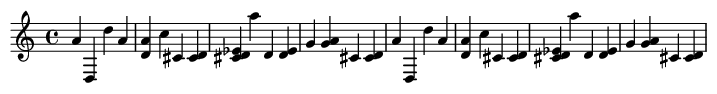

'Baseline_Generated_Neutral_Melody.mid'

In [ ]:
#Neutral:
neutral_sorted_note_occurence_dictionary = count_occurence_of_note(neutral_notes, neutral_unique_notes)
neutral_notes_generated, neutral_melody_midi = Baseline_Model(20, neutral_sorted_note_occurence_dictionary)
show(neutral_melody_midi)

neutral_melody_midi.write('midi','Baseline_Generated_Neutral_Melody.mid')

In [ ]:
#Sad:
sad_sorted_note_occurence_dictionary = count_occurence_of_note(sad_notes, sad_unique_notes)
sad_notes_generated, sad_melody_midi = Baseline_Model(20, sad_sorted_note_occurence_dictionary)
show(sad_melody_midi)

sad_melody_midi.write('midi','Baseline_Generated_Sad_Melody.mid')

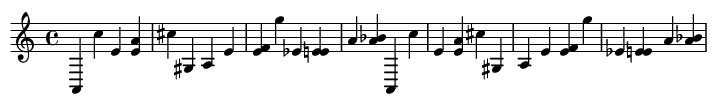

'Baseline_Generated_Surprise_Melody.mid'

In [ ]:
#Surprise:
surprise_sorted_note_occurence_dictionary = count_occurence_of_note(surprise_notes, surprise_unique_notes)
surprise_notes_generated, surprise_melody_midi = Baseline_Model(20, surprise_sorted_note_occurence_dictionary)
show(surprise_melody_midi)

surprise_melody_midi.write('midi','Baseline_Generated_Surprise_Melody.mid')

## **Combine the two Models**

In [ ]:
# 0 - angry 
# 1 - fear 
# 2 - happy 
# 3 - neutral 
# 4 - sad 
# 5 - surprise 

# Load CNN model
model = EmotionNet(num_of_channels=1, num_of_classes=num_of_classes)
state = torch.load("model_cnn")
model.load_state_dict(state)

# Load RNN model 
def classification_to_label(classification):
    if classification == 0:
        predicted_emotion = "angry"
        chosen_music_model = AngryMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.0001_emotionAngry")
        chosen_music_model.load_state_dict(state)
        notes = angry_notes
        note_to_index = angry_note_to_index
        index_to_note = angry_index_to_note
        length_unique_note = angry_length_unique_notes
    elif classification == 1:
        predicted_emotion = "fear"
        chosen_music_model = FearMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.001_emotionFear")
        chosen_music_model.load_state_dict(state)
        notes = fear_notes
        note_to_index = fear_note_to_index
        index_to_note = fear_index_to_note
        length_unique_note = fear_length_unique_notes
    elif classification == 2:
        predicted_emotion = "happy"
        chosen_music_model = HappyMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.001_emotionHappy")
        chosen_music_model.load_state_dict(state)
        notes = happy_notes
        note_to_index = happy_note_to_index
        index_to_note = happy_index_to_note
        length_unique_note = happy_length_unique_notes
    elif classification == 3:
        predicted_emotion = "neutral"
        chosen_music_model = NuetralMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.0008_emotionNeutral")
        chosen_music_model.load_state_dict(state)
        notes = neutral_notes
        note_to_index = neutral_note_to_index
        index_to_note = neutral_index_to_note
        length_unique_note = neutral_length_unique_notes
    elif classification == 4: 
        predicted_emotion = "sad"
        chosen_music_model = SadMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.0009_emotionSad")
        chosen_music_model.load_state_dict(state)
        notes = sad_notes
        note_to_index = sad_note_to_index
        index_to_note = sad_index_to_note
        length_unique_note = sad_length_unique_notes
    elif classification == 5:
        predicted_emotion = "surprise"
        chosen_music_model = SurpriseMusicRNN()
        state = torch.load("model_Tune_bs32_lr0.0009_emotionSurprise")
        chosen_music_model.load_state_dict(state)
        notes = surprise_notes
        note_to_index = surprise_note_to_index
        index_to_note = surprise_index_to_note
        length_unique_note = surprise_length_unique_notes

    return predicted_emotion, chosen_music_model, notes, note_to_index, index_to_note, length_unique_note

# Load uploaded test image and tranform
# uploaded_image = image.open("/content/sample_image.jpg")
uploaded_image = image.open("/content/demo_martin.jpg")
transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    ToTensor()
])

uploaded_image = transform(uploaded_image)
uploaded_image = uploaded_image.reshape(1, 1, 48, 48)

# Get the predicted CNN output
output = model(uploaded_image)
output = output.argmax(axis=1).cpu().numpy()
# Select the RNN and get the melody generated by the RNN  
predicted_emotion, chosen_music_model, notes, note_to_index, index_to_note, length_unique_notes = classification_to_label(output)
music, melody = melody_generator(16, 20, notes, note_to_index, index_to_note, length_unique_notes, chosen_music_model)

display_image = image.open("/content/sample_image.jpg")
display(display_image.resize((100, 100)))
print(f"The predicted emotion is {predicted_emotion}")
show(melody)
melody.write('midi','generated_music.mid')